### Import dei pacchetti

In [1]:
gdrive = False

In [2]:
import sys
import os
if gdrive:
    from google.colab import drive
    drive.mount('/content/gdrive')
    %tensorflow_version 1.x
    sys.path.append('/content/gdrive/My Drive/Tesi/src/')
    ROOT_DIR = "/content/gdrive/My Drive/Tesi/"
    data_path = "/content/gdrive/My Drive/Tesi/processedData/speaker1/train&validation/"
    !pip install deepspeech
    !apt-get install sox libsox-dev libsox-fmt-all
    !pip install jiwer
else:
    ROOT_DIR = os.path.dirname(os.path.abspath('.'))
    data_path = ROOT_DIR + "\\processedData\\speaker1\\train&validation\\"

In [4]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import tensorflow as tf
import seaborn as sns
from training_ops import *
import matplotlib.pyplot as plt
import IPython.display as ipd
import scipy
from dataset import DataSet
import pandas as pd
import librosa
from params import *
import soundfile as sf
from tqdm.notebook import tqdm
from evaluation_ops import *
import jiwer

ModuleNotFoundError: No module named 'deepspeech'

### Import del modello

In [5]:
multispeaker = True
data_path = read_datapath(multispeaker = multispeaker, gdrive = gdrive)
architecture_params, opt_params = read_params('tfnet')
#dir_name = 'gionet.lr0.000030dec.4.g3.b128'
#architecture_params, opt_params = read_params_from_logdir(os.path.join(data_path, 'model_ckpt/{}'.format(dir_name))) #gionet.lr0.000030dec.4.g4.b128

In [6]:
if multispeaker:
    read_best_model = True
else:
    read_best_model = False

In [7]:
logdir = get_logdir(data_path, opt_params, architecture_params)
checkpoint_root = os.path.join(logdir, 'model.ckpt')
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, allow_soft_placement=True, log_device_placement=True))
if os.path.isdir(logdir):
    print('Model loading...')
    if read_best_model:
        checkpoint = os.path.join(logdir, 'best_model')
    else: 
        checkpoint = read_latest_checkpoint(logdir, gdrive)
    meta = checkpoint + '.meta'
    saver = tf.train.import_meta_graph(meta)
    g = tf.get_default_graph()
    saver.restore(sess, checkpoint)
    X_lr, Y, alpha = tf.get_collection('inputs')[0:3]
    inputs = (X_lr, Y, alpha)
    predictions = tf.get_collection('preds')[0]
    with open(os.path.join(logdir, 'train_metrics.pickle'), 'rb') as handle:
        train_metrics = pickle.load(handle)

Model loading...


ValueError: Value for attr 'T' of complex64 is not in the list of allowed values: float, double
	; NodeDef: {{node gradients/fusion/spectral_transform/Abs_grad/div_no_nan}}; Op<name=DivNoNan; signature=x:T, y:T -> z:T; attr=T:type,allowed=[DT_FLOAT, DT_DOUBLE]>

### Weight variable analysis
Quello rappresentato in figura è il peso associato alla magnitude della spectral net. In tfnet i valori si aggirano intorno allo 0.5 -> E' importante nella stima finale. In gionet intorno allo zero -> Pesa poco nella stima della magnitude finale, ed è un ramo che si dedica solo a quello in pratica. Perciò è come se in gionet la stima finale del segnale hr sia data soltanto dal ramo del dominio temporale.

In [ ]:
clamp =lambda x: (tf.tanh(x)+1)/2

In [ ]:
all_vars = tf.global_variables()
for i in all_vars:
    if i.name == 'fusion/fusion_weights_unclamped:0':
        var_uncl = i
        break
print(var_uncl.name)
v0 = sess.run(var_uncl)
weigths_values = np.squeeze(v0)
weigths_values_clamped = sess.run(clamp(weigths_values)) 
sns.displot(weigths_values_clamped, kind="kde")

### Analisi del training 

In [ ]:
with open(os.path.join(logdir, 'train_metrics.pickle'), 'rb') as handle:
        train_metrics = pickle.load(handle)

In [ ]:
df = pd.DataFrame.from_dict(train_metrics, orient = 'index')#.reset_index().rename({'index':'epoch'}, axis = 1)

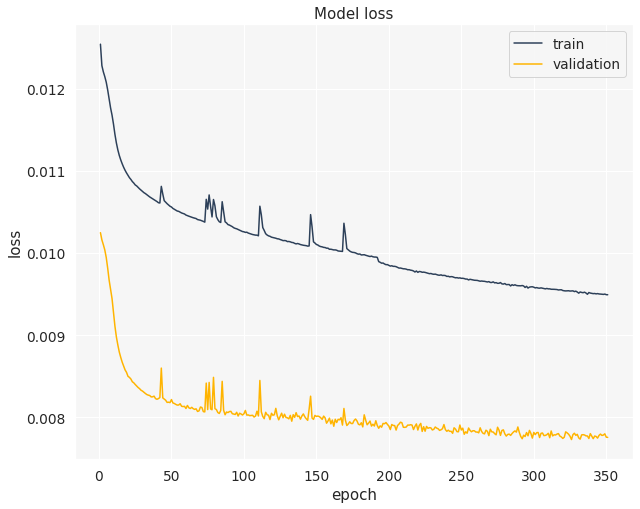

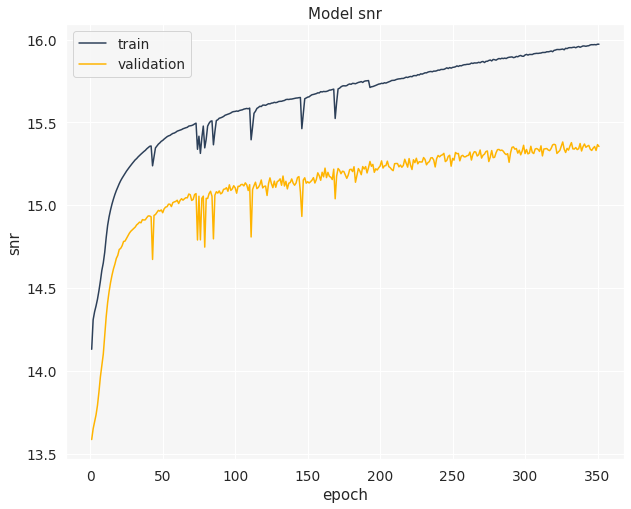

In [ ]:
plt.figure(figsize=(10,8))
plot_training_curves(df['l2_training'], df['l2_validation'])
plt.figure(figsize=(10,8))
plot_training_curves(df['snr_training'], df['snr_validation'], y_axis = 'snr')

### Calcolo metriche di errore

In [ ]:
def calc_snr_lsd(input_x, input_y, inputs, predictions, sess, alpha = 1, batch_size=128):
    assert input_x.shape[0]%batch_size == 0
    data = DataSet(input_x, input_y, epochs_completed = 0)
    snr_on_batch = []
    snr_on_batch_std = []
    lsd_on_batch = []
    lsd_on_batch_std = []
    for i in tqdm(range(int(input_x.shape[0]/batch_size))): # 1 epoch
        batch = data.next_batch(batch_size)
        Y_batch = batch[1]
        feed_dict_not_train = load_batch(inputs, batch, alpha, train=False)
        result_tr = sess.run(predictions, feed_dict = feed_dict_not_train)
        snr_mean, snr_std = calc_snr2(Y_batch, result_tr, return_std = True)
        snr_on_batch.append(snr_mean)
        snr_on_batch_std.append(snr_std)
        lsd_list = [compute_log_distortion(np.squeeze(result_tr[i]), np.squeeze(Y_batch[i])) for i in range(result_tr.shape[0])]   
        lsd_on_batch.append(np.mean(lsd_list))
        lsd_on_batch_std.append(np.std(lsd_list))
    return np.mean(snr_on_batch), np.mean(snr_on_batch_std), np.mean(lsd_on_batch), np.mean(lsd_on_batch_std) 

In [7]:
def calc_snr_lsd_spline(input_x, input_y, batch_size=128):
    assert input_x.shape[0]%batch_size == 0
    data = DataSet(input_x, input_y, epochs_completed = 0)
    snr_on_batch = []
    snr_on_batch_std = []
    lsd_on_batch = []
    lsd_on_batch_std = []
    for i in tqdm(range(int(input_x.shape[0]/batch_size))): # 1 epoch
        batch = data.next_batch(batch_size)
        snr_mean, snr_std = calc_snr2(batch[1], batch[0], return_std = True)
        snr_on_batch.append(snr_mean)
        snr_on_batch_std.append(snr_std)
        lsd_list = [compute_log_distortion(np.squeeze(batch[0][i]), np.squeeze(batch[1][i])) for i in range(batch[0].shape[0])]   
        lsd_on_batch.append(np.mean(lsd_list))
        lsd_on_batch_std.append(np.std(lsd_list))
    return np.mean(snr_on_batch), np.mean(snr_on_batch_std), np.mean(lsd_on_batch), np.mean(lsd_on_batch_std) 

In [8]:
%%time
if multispeaker:
    sample_training = True
else:
    sample_training = False
X_train, Y_train, X_val, Y_val = read_data(data_path, sample_training = sample_training)
n_train, n_validation = X_train.shape[0], X_val.shape[0]

CPU times: user 109 ms, sys: 380 ms, total: 489 ms
Wall time: 4.96 s


In [ ]:
%%time
val_snr_mean, val_snr_std, val_lsd_mean, val_lsd_std = calc_snr_lsd(X_val, Y_val, inputs, predictions, sess)


CPU times: user 5.9 s, sys: 1.32 s, total: 7.22 s
Wall time: 7.15 s


In [ ]:
print(val_snr_mean)
print(val_snr_std)
print(val_lsd_mean)
print(val_lsd_std)

17.100584
3.565324
3.4805171
0.82669663


In [ ]:
%%time
val_snr_mean_spline, val_snr_std_spline, val_lsd_mean_spline, val_lsd_std_spline = calc_snr_lsd_spline(X_val, Y_val)
print(val_snr_mean_spline)
print(val_snr_std_spline)
print(val_lsd_mean_spline)
print(val_lsd_std_spline)


13.599438
4.8045225
5.9712973
1.3759665
CPU times: user 2min 6s, sys: 16 s, total: 2min 22s
Wall time: 2min 22s


In [ ]:
del X_val
del Y_val

In [9]:
%%time
train_snr_mean_spline, train_snr_std_spline, train_lsd_mean_spline, train_lsd_std_spline = calc_snr_lsd_spline(X_train, Y_train)


CPU times: user 20.3 s, sys: 304 ms, total: 20.6 s
Wall time: 20.5 s


In [10]:
print(train_snr_mean_spline)
print(train_snr_std_spline) 
print(train_lsd_mean_spline)
print(train_lsd_std_spline)

14.744431
4.424209
5.640473
1.8516519


In [ ]:
del X_train
del Y_train

In [ ]:
hf = h5py.File(data_path + 'test_data.hdf5', 'r')
X_test, Y_test = np.array(hf.get('data_lr')), np.array(hf.get('label'))
test_snr_mean_spline, test_snr_std_spline, test_lsd_mean_spline, test_lsd_std_spline = calc_snr_lsd_spline(X_test, Y_test)
print(test_snr_mean_spline)
print(test_snr_std_spline)
print(test_lsd_mean_spline)
print(test_lsd_std_spline)


14.064825
4.312431
5.63571530543207
1.4059294249449432


In [ ]:
%%time
train_snr_mean, train_snr_std, train_lsd_mean, train_lsd_std = calc_snr_lsd(X_train, Y_train, inputs, predictions, sess)
print(train_snr_mean)
print(train_snr_std) 
print(train_lsd_mean)
print(train_lsd_std)

In [ ]:
%%time
if multispeaker:
    hf = h5py.File(data_path + 'test_data.hdf5', 'r')
    X_test, Y_test = np.array(hf.get('data_lr')), np.array(hf.get('label'))
    test_snr_mean, test_snr_std, test_lsd_mean, test_lsd_std = calc_snr_lsd(X_test, Y_test, inputs, predictions, sess)
    print(test_snr_mean)
    print(test_snr_std)
    print(test_lsd_mean)
    print(test_lsd_std)
    del X_test
    del Y_test
else:
    test_snr_mean, test_snr_std, test_lsd_mean, test_lsd_std = val_snr_mean, val_snr_std, val_lsd_mean, val_lsd_std
    val_snr_mean, val_snr_std, val_lsd_mean, val_lsd_std = None, None, None, None

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 10.3 µs


In [ ]:
df_results = df_from_results(train_snr = train_snr_mean,
                train_snr_std = train_snr_std,
                val_snr = val_snr_mean,
                val_snr_std = val_snr_std,
                test_snr = test_snr_mean,
                test_snr_std = test_snr_std,
                train_lsd = train_lsd_mean,
                train_lsd_std = train_lsd_std,
                val_lsd = val_lsd_mean,
                val_lsd_std = val_lsd_std, 
                test_lsd = test_lsd_mean,
                test_lsd_std = test_lsd_std,
                savepath = logdir) #if you insert save path dataframe will be saved!

DataFrame is successfully saved!


In [ ]:
df_results

,snr_mean,snr_std,lsd_mean,lsd_std
train,16.014538,4.979925,3.642848,0.878964
val,NaN,NaN,NaN,NaN
test,17.100584,3.565324,3.480517,0.826697


### Risultati speech-to-text

In [ ]:
path_deepspeech_model = os.path.join(ROOT_DIR, 'processedData', 'speech_to_text_models')
model = get_deepspeech_model(path_deepspeech_model)
data_path = os.path.join(ROOT_DIR, 'rawData', 'VCTK-Corpus', 'wav48')
file_list = []
if multispeaker:
    txt_file = os.path.join(ROOT_DIR, 'processedData', 'txtfiles', 'test-speakers.txt')
    id_list = from_txt_to_list(txt_file)
    for speaker_id in id_list:
        data_dir = os.path.join(data_path, speaker_id)
        real_txt_dir = os.path.join(ROOT_DIR, 'rawData', 'VCTK-Corpus', 'txt', speaker_id)
        for file_ in os.listdir(data_dir):
            filename = file_.strip()
            real = os.path.splitext(filename)[0] + '.txt'
            file_list.append((os.path.join(data_dir, filename), os.path.join(real_txt_dir, real)))
else:
    txt_file = os.path.join(ROOT_DIR, 'processedData', 'txtfiles', 'speaker1-val-files.txt')
    data_dir = os.path.join(data_path, 'p225')
    real_txt_dir = os.path.join(ROOT_DIR, 'rawData', 'VCTK-Corpus', 'txt', 'p225')
    for file_ in from_txt_to_list(txt_file):
        filename = file_.strip()
        real = os.path.splitext(filename)[0] + '.txt'
        file_list.append((os.path.join(data_dir, filename), os.path.join(real_txt_dir, real)))

In [ ]:
%%time
temporary_file_dir = os.path.join(ROOT_DIR, 'processedData', 'temp_files')
fs = 16000
assert fs == model.sampleRate()
results = {}
for f in tqdm(file_list):
    try:
        audio_file_path = f[0]
        real_txt_transcription_path = f[1]
        real_txt_transcription = from_txt_to_list(real_txt_transcription_path)[0]
        sig, rate = librosa.load(audio_file_path, sr=fs, mono=False)
        sig = pre_process_signal(sig)
        f1 = ModelOnSingleFile(sig, rate, architecture_params['r'], sess, inputs, predictions, interp = True)
        sf.write(os.path.join(temporary_file_dir, 'low_res.wav'), f1.low_res(), rate)
        sf.write(os.path.join(temporary_file_dir, 'high_res.wav'), f1.get_model_hr(), rate)
        sf.write(os.path.join(temporary_file_dir, 'original_res.wav'), f1.original_version(), rate)

        original_file_trascription = get_txt(os.path.join(temporary_file_dir, 'original_res.wav'), model, fs, gdrive)
        low_res_file_trascription = get_txt(os.path.join(temporary_file_dir, 'low_res.wav'), model, fs, gdrive)
        model_hr_file_trascription = get_txt(os.path.join(temporary_file_dir, 'high_res.wav'), model, fs, gdrive)

        wer_original = calc_wer(real_txt_transcription, original_file_trascription)
        wer_low_res = calc_wer(real_txt_transcription, low_res_file_trascription)
        wer_model_hr = calc_wer(real_txt_transcription, model_hr_file_trascription)

        results[len(results.keys())] = {'wer_original': wer_original, 
                                    'wer_low_res': wer_low_res,
                                    'wer_model_hr': wer_model_hr}
    except:
        pass

df_results_stt = df_from_results_stt(results, savepath = logdir)
#clean_temp_directory(temporary_file_dir)


DataFrame of speech to text results is successfully saved!
CPU times: user 4min 44s, sys: 5.02 s, total: 4min 49s
Wall time: 5min 20s


In [ ]:
df_results_stt

,wer_original,wer_low_res,wer_model_hr
mean,0.033668,0.51927,0.441257
std,0.056555,0.22091,0.230352
